### Libraries

In [1]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage.interpolation import zoom
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
#!pip install git+https://github.com/facebookresearch/fvcore.git

/tmp/ipykernel_415920/2065809747.py:17: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [2]:
pwd

'/scratch/student/shokoofa/Thesis-experiments'

In [3]:
original_address = '/scratch/student/shokoofa/'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [4]:
paths = glob.glob(os.path.join(original_address + '/dataset/**/*', '*')) #numebr of all samples per patients
len(paths)

5303

### Load the csv file containing the image file names and corresponding labels

In [5]:
info_train = pd.read_csv(os.path.join(original_address , 'train_labels_original.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'val_labels_original.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'test_labels_original.csv'))

In [6]:
len(info_train['label'])

2522

In [7]:
info_train['path'][100], info_train['label'][100]

('Train/6VLObFIMTzq7fyUz9-ltQA/64', 'Apical-3ch')

### Preprocessing

### Define Transformers

In [8]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))
    
class AddGaussianNoise:
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    

to_pil = ToPILImage()
    

all_data_transform = transforms.Compose([
    CustomCrop(),
    transforms.Resize((224, 224)),
    # transforms.Resize((256, 256)), #efficientNet-b0
    # transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Lambda(lambda x: x/255),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # AddNormalization()
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.2),  # Brightness & contrast
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.2),
    
])


### Map images to their labels

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform, training_transform = None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.training_transform = training_transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, label, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1
        output = image_array * mask
        # visualization(mask[0], label)
        return output

    def address(self,index):
        return original_address + '/dataset/' + self.paths[index]
    
                
    def __getitem__(self, index):
        # Get the filename and label for the current index
        filepath = original_address + '/dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])


        # sort the image in based on the order of the slices saved in the folder
        addresses = glob.glob(os.path.join(filepath + '/', '*'))

        images_list = []
        for img_path in addresses[:10]:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)
            
        sequence_tensor = torch.stack(images_list)
        preprocessed_sequence = self.preprocessing(sequence_tensor, label)

        image = preprocessed_sequence[int(len(preprocessed_sequence)//2)]
        if self.training_transform is not None:
            image = self.training_transform(to_pil(image))

        return image, label

In [10]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [11]:
train_data = CustomDataset(info_train['path'], info_train['label'], transform=all_data_transform, training_transform=train_transform)
val_data = CustomDataset(info_val['path'], info_val['label'], transform=all_data_transform)
test_data = CustomDataset(info_test['path'], info_test['label'], transform=all_data_transform)

In [12]:
test_data.address(10)

'/scratch/student/shokoofa//dataset/Test/2TmBIz3oRY6M5Iicg6qIrQ/23'

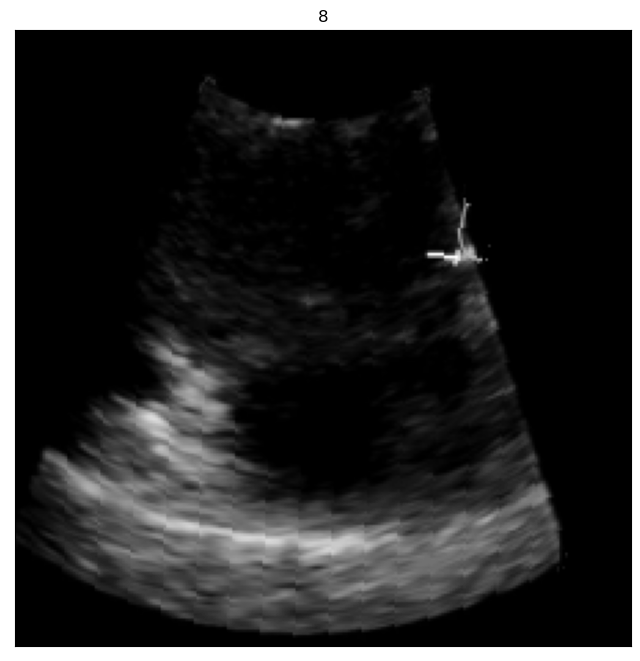

tensor(0.9961)

In [13]:
visualization(train_data[364][0][0],train_data[1][1] )
train_data[87][0][0].max()

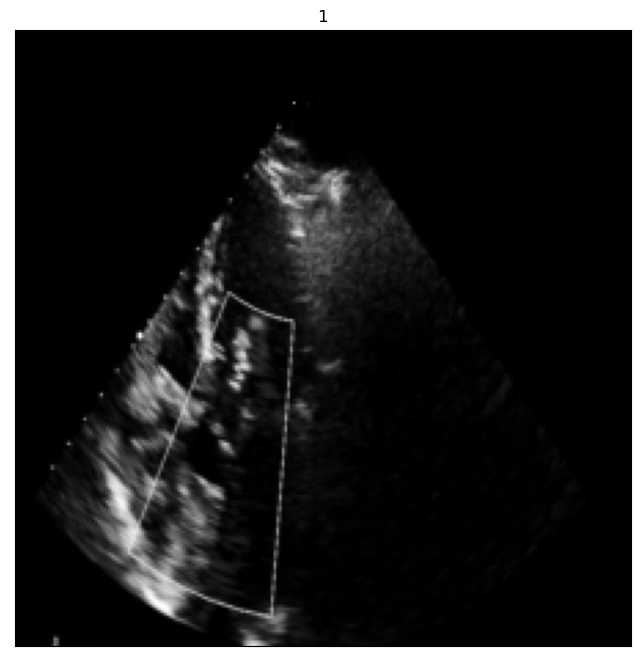

In [14]:
visualization(test_data[89][0][0], test_data[30][1])

### Create data loaders for the train and validation sets



In [15]:
train_loader = DataLoader(train_data, batch_size=64, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=64, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=64, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [16]:
len(val_data)

257

In [17]:
# for i, (img, lbl) in enumerate(train_loader):
#     print(img.shape)
#     print(i)

### Define the neural network model architecture

In [56]:
class CNNLSTM(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        # self.conv = torchvision.models.resnet18(pretrained = False)
        # self.conv = torchvision.models.efficientnet_b2(pretrained=True)
        self.conv = torchvision.models.googlenet(pretrained=False,dropout = 0.3)

        # self.conv = torchvision.models.inception_v3(weights='DEFAULT')

        self.classifier_layer = nn.Sequential( nn.Linear(self.cnn_output_size, num_classes))

    def forward(self, x):
        batch_size , C, H, W = x.size()
        c_out = self.conv(x)
        c_out = c_out[0] #just google net
        output = self.classifier_layer(c_out)
        return output

cnn_output_size = 1000
model = CNNLSTM(3,cnn_output_size, 11)

In [57]:
input1 = torch.rand(8, 3, 256, 256)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
print(model(input1))
# print(model(input2))

tensor([[ 0.1074, -0.1229,  0.1818, -0.0052, -0.1402,  0.0555,  0.0213, -0.0096,
          0.0567, -0.1126, -0.0332],
        [ 0.2480, -0.1155,  0.1396, -0.1022, -0.0198,  0.0259, -0.0738, -0.0488,
         -0.0622, -0.0406, -0.1714],
        [ 0.1100, -0.1023,  0.1758, -0.0964, -0.0047,  0.0884,  0.0508, -0.0689,
         -0.0047, -0.0065, -0.0766],
        [ 0.1180, -0.0949,  0.1364, -0.0495,  0.0344,  0.0421,  0.0570, -0.0216,
          0.0320,  0.0727, -0.1261],
        [ 0.2237, -0.1974,  0.0811, -0.0348, -0.1236,  0.1292,  0.0830,  0.0042,
         -0.0279, -0.0381, -0.0692],
        [ 0.1967, -0.1099,  0.1504, -0.1397, -0.1141,  0.0408, -0.0494, -0.0257,
          0.0173, -0.1570,  0.0137],
        [ 0.1563, -0.0776,  0.2125, -0.0232, -0.0085,  0.0019,  0.0421,  0.0170,
         -0.0469,  0.0418, -0.0788],
        [ 0.2274, -0.1509,  0.1407, -0.0583, -0.1133,  0.0179,  0.0079, -0.0507,
          0.0499, -0.0460,  0.0111]], grad_fn=<AddmmBackward0>)


### Define loss and optimizer

In [52]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(device)

cuda


In [62]:
i= 0
for img, lbl in val_loader:
    if(i<5):
        model.eval()
        images = img.to(device)
        labels = lbl.to(device)
        labels = labels.squeeze(1)
        print(labels)
        output = model(images)
        output = output.unsqueeze(0)
        print(output)
        _, predictions = output.max(1)
        # print(output)
        print(predictions)
        loss = criterion(output, labels)
        print(loss.item())
        print((predictions == labels).sum())
        i += 1
    


tensor([ 0,  2,  0,  9,  7,  4,  7,  1,  3,  8,  7,  0,  0,  2,  8, 10,  3,  8,
         7,  8,  8,  6,  8,  1,  0,  0,  8,  8,  8,  8,  0,  2,  2,  0,  1,  8,
         9,  0,  5,  8,  0,  8,  1,  5,  3, 10,  0,  2,  1,  8, 10, 10,  3, 10,
        10,  8,  8,  5,  2,  1,  5,  0,  8, 10], device='cuda:0')
tensor([[-0.0148, -0.0177,  0.0091, -0.0307, -0.0240,  0.0187, -0.0183,  0.0226,
         -0.0137,  0.0272, -0.0481]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)
tensor([9], device='cuda:0')


ValueError: Expected input batch_size (1) to match target batch_size (64).

### Train the model

In [ ]:
def evaluate(model, loader, device, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      total_loss += loss.item() * images.size(0)
      # print('Valid \t',  predictions, labels, labels == predictions, total_correct, total, images.size(0), '\n')

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [ ]:
# model = model.to(device)
epochs = 30
# BATCH_SIZE = 64
accs = []
losses = []
val_loss = 0.0
best_val_loss = float('inf')
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  # epochs_no_improve = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # print('TRAIN:', predictions, labels,  running_corrects, '\n')
    # total_loss += loss.item() * images.size(0)
    
  # accuracy = total_correct / total

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 6 and epoch > 20:
    print('no further improvement ', best_acc)
    break


TypeError: linear(): argument 'input' (position 1) must be Tensor, not GoogLeNetOutputs

In [38]:
def evaluate(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print('Valid \t',  predictions, labels, labels == predictions, total_correct, total, images.size(0), '\n')

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss

evaluate(model, loader= test_loader, device = device)


Test Loss(0.8210),  Accuracy (0.7969))


(tensor(0.7969, device='cuda:0'), 0.8209943175315857)

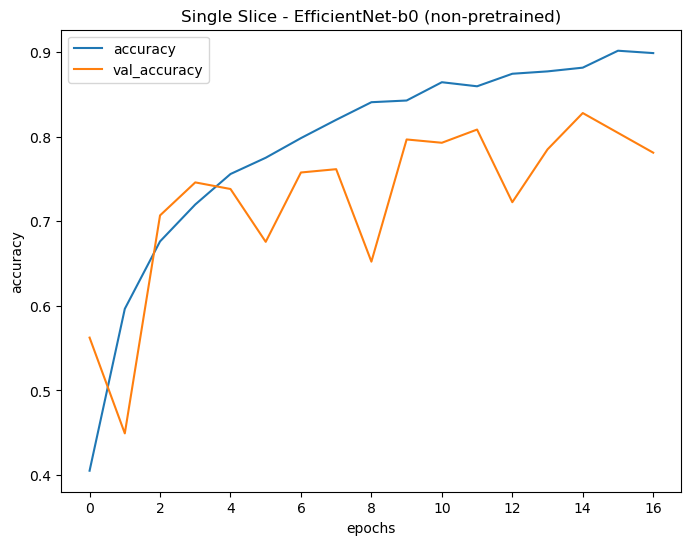

In [36]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Single Slice - EfficientNet-b0 (non-pretrained)')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [27]:
# predictions == labels

In [28]:
# model.load_state_dict(torch.load('/home/student/shokoofa/Downloads/model0.pth'))
# model.eval()

In [29]:
# print(model(test_data[183][0].unsqueeze(0).to(device)))
# # test_data[0][0].unsqueeze(0).shape
# # images.size()

# test_data[183][1]

In [30]:
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()

#         self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv.trainable = False
#         for param in self.conv.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         seq_len, C, H, W = x.size()
#         c_in = x.view( seq_len, C, H, W)
#         c_out = self.conv.extract_features(c_in)
#         pooled = F.adaptive_avg_pool2d(c_out, (1,1))
#         pooled = pooled.view(seq_len, -1)
#         return pooled


# # x = torch.rand((1, 20, 1, 32, 32))
# xx = [torch.rand( i, 3, 224, 224) for i in range(25,30)]
# net_cnn = CNN(1)
# for x in xx:
#     features = net_cnn(x)
#     print(features.shape)

In [31]:
# class VGG(nn.Module):
#   def __init__(self, num_classes=100):
#     super().__init__()
#     self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#     )

#     self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
#     self.flatten = nn.Flatten(start_dim=1)
#     self.classifier = nn.Sequential(
#             nn.Linear(256*256*512, num_classes),
#             nn.ReLU(inplace=True),
#             # nn.Linear(1000, 100),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(1000, num_classes),
#             # nn.ReLU(inplace=True),
#         )

#   def forward(self, x):
#     x = self.features(x)
#     # x = self.adaptive_avg_pool2d(x)
#     x = self.flatten(x)
#     x = self.classifier(x)
#     return x

In [32]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break

In [33]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break



In [34]:
# torch.save(model.state_dict(), 'model.pt')
